<a href="https://colab.research.google.com/github/amutharun/RAG/blob/main/06_Self_Query_Retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Self Query Retriever
A self-querying retriever can query itself using natural language queries.
It employs a query-constructing language model (LLM) chain to create a structured query.
The retriever applies this structured query to its VectorStore, enabling semantic similarity comparisons with stored documents.
Additionally, the retriever can extract filters from user queries related to metadata of stored documents and execute them.
Overall, it enhances the retriever's ability to interact with and retrieve information based on both semantic content and metadata filters.

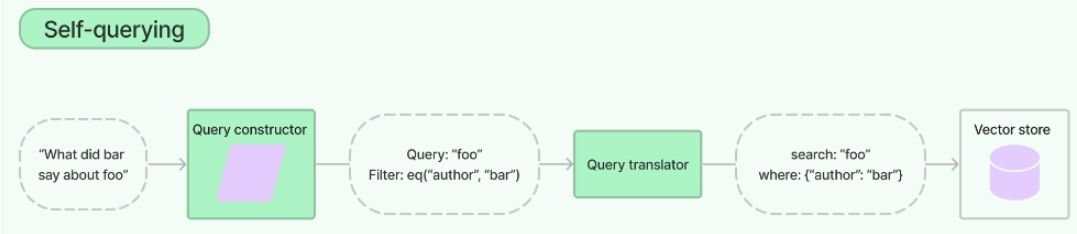

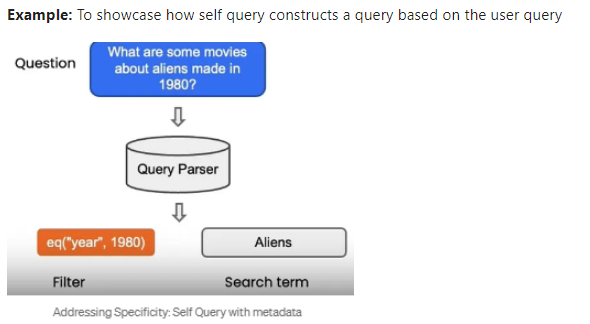

In [2]:
!git clone https://github.com/amutharun/RAG.git

Cloning into 'RAG'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 70 (delta 33), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (70/70), 9.60 MiB | 14.29 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
!pip install -r /content/RAG/rag_requirements.txt

In [5]:
import os
import time
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()

True

In [7]:
# Setting up the env vars

# if directly using open ai api key
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_type = "openai"

# # Fetch the Azure Open AI env variables
# GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')
# API_KEY = os.getenv('API_KEY')
# API_BASE = os.getenv('API_BASE')
# API_TYPE = os.getenv('API_TYPE')
# API_VERSION = os.getenv('API_VERSION')

# EMBEDDING_API_KEY = os.getenv('API_KEY')
# EMBEDDING_API_BASE = os.getenv('API_BASE')
# EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')

In [9]:
%pip install --upgrade --quiet  langchain lark chromadb

In [27]:
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain.embeddings.openai import OpenAIEmbeddings

docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "director": "Andrei Tarkovsky",
            "genre": "thriller",
            "rating": 9.9,
        },
    ),
    Document(
        page_content="A brilliant scientist builds a humanoid robot to protect mankind, but things go awry when the robot falls in love and causes mayhem.",
        metadata={
            "year": 2010,
            "director": "S. Shankar",
            "genre": "science fiction",
            "rating": 7.1,
        },
    )

]
vectorstore = Chroma.from_documents(docs, OpenAIEmbeddings())

In [13]:
from langchain.chat_models import AzureChatOpenAI, ChatOpenAI

# Open AI way
llm = ChatOpenAI(model="gpt-4-0125-preview",temperature=0)

# Azure Open AI way
# llm = AzureChatOpenAI(
#         openai_api_base=API_BASE,
#         openai_api_version=API_VERSION,
#         deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
#         openai_api_key=API_KEY,
#         openai_api_type=API_TYPE,
#         temperature=0
#     )

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [17]:
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)


In [23]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever


metadata_field_info = [
    AttributeInfo(
        name="genre",
        description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="A 1-10 rating for the movie", type="float"
    ),
]
document_content_description = "Brief summary of a movie"
llm = ChatOpenAI(temperature=0)
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info, verbose=True
)

In [24]:
# This example only specifies a filter
retriever.invoke("I want to watch a movie rated higher than 8.5")

[Document(page_content='Three men walk into the Zone, three men walk out of the Zone', metadata={'director': 'Andrei Tarkovsky', 'genre': 'thriller', 'rating': 9.9, 'year': 1979}),
 Document(page_content='A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea', metadata={'director': 'Satoshi Kon', 'rating': 8.6, 'year': 2006})]

In [18]:
# This example specifies a query and a filter
retriever.invoke("Has Greta Gerwig directed any movies about women")

[Document(page_content='A bunch of normal-sized women are supremely wholesome and some men pine after them', metadata={'director': 'Greta Gerwig', 'rating': 8.3, 'year': 2019})]

In [22]:
retriever.invoke("suggest some thriller movies before 1980")

[Document(page_content='Three men walk into the Zone, three men walk out of the Zone', metadata={'director': 'Andrei Tarkovsky', 'genre': 'thriller', 'rating': 9.9, 'year': 1979})]

In [26]:
retriever.invoke("were there any animation movies released between 1990 and 2000?")

[Document(page_content='Toys come alive and have a blast doing so', metadata={'genre': 'animated', 'year': 1995})]

In [32]:
retriever.invoke("give me a list of movies directed by S. Shankar")

[Document(page_content='A brilliant scientist builds a humanoid robot to protect mankind, but things go awry when the robot falls in love and causes mayhem.', metadata={'director': 'S. Shankar', 'genre': 'science fiction', 'rating': 7.1, 'year': 2010})]

In [33]:
retriever.invoke("When was the move Enthiran released?")

[Document(page_content='A brilliant scientist builds a humanoid robot to protect mankind, but things go awry when the robot falls in love and causes mayhem.', metadata={'director': 'S. Shankar', 'genre': 'science fiction', 'rating': 7.1, 'year': 2010}),
 Document(page_content='A bunch of scientists bring back dinosaurs and mayhem breaks loose', metadata={'genre': 'science fiction', 'rating': 7.7, 'year': 1993}),
 Document(page_content='A bunch of scientists bring back dinosaurs and mayhem breaks loose', metadata={'genre': 'science fiction', 'rating': 7.7, 'year': 1993}),
 Document(page_content='Toys come alive and have a blast doing so', metadata={'genre': 'animated', 'year': 1995})]